In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from mlxtend.regressor import LinearRegression

In [2]:
INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_main_new'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select "EM_TOTAL_Import_Energy(kWh)", "DeviceID", "time" from ' + TARGET_MEASUREMENT + ' where time > now() - 15d '
df1 = pd.DataFrame(con_obj.query(query).get_points())
df1['time'] = df1['time'].astype('datetime64[ns]')

In [3]:
date_old = (pd.datetime.now().date() - pd.offsets.Day(15))
date_now = pd.datetime.now().date() - pd.offsets.Day(1)
df2 = df1[(df1['time'] >= date_old) & (df1['time'] < date_now)]
df2 = df2[['time', 'EM_TOTAL_Import_Energy(kWh)','DeviceID']]

In [4]:
pd.datetime.now().date() - pd.offsets.Day(1)

Timestamp('2020-06-29 00:00:00')

In [5]:
df3 = df2.copy()
df3 = df3.set_index("time")
print(df3.index.min())
print(df3.index.max())

2020-06-15 04:35:55.274622
2020-06-28 23:59:59.631051


In [6]:
df2.head(2)

,time,EM_TOTAL_Import_Energy(kWh),DeviceID
0,2020-06-15 04:35:55.274622,726253.5,EM8
1,2020-06-15 04:35:56.038849,3353.0,EM2


In [7]:
df2.tail(2)

,time,EM_TOTAL_Import_Energy(kWh),DeviceID
3909791,2020-06-28 23:59:59.306315,45.6,EM7
3909792,2020-06-28 23:59:59.631051,261730.0,EM4


In [8]:
class half_an_hour_min_energy:  
    
    def difference(self,df2):
        diff = []
        for g,i in df2.groupby(pd.Grouper(freq ='30T',key ='time'))['EM_TOTAL_Import_Energy(kWh)']:
            try:
                diff.append([g,i.iloc[-1]-i.iloc[0]])
            except:
                diff.append([g,np.nan])
        x=pd.DataFrame(diff)
        return x        
                
    def output(self, df2):
            y = df2.groupby('DeviceID').apply(self.difference)
            y = y.pivot_table(index = 0,columns ='DeviceID',values = 1).reset_index()
            y.columns.name = None
            y = y.rename(columns = {0: ""})
            y = y.set_index("")
            y = y.fillna(0)
            return y

In [9]:
cat = half_an_hour_min_energy()
df = cat.output(df2)
df.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
,,,,,,,,,,,,
2020-06-15 04:30:00,511.0,19.7,0.0,1.3,9.9,0.0,135.0,140.0,0.4,0.0,32.8,23.3
2020-06-15 05:00:00,617.0,24.5,0.0,1.9,12.3,0.0,138.0,167.0,0.4,0.1,40.9,29.7
2020-06-15 05:30:00,590.0,22.9,0.0,1.9,12.3,0.0,111.0,170.0,0.0,0.0,38.9,27.7
2020-06-15 06:00:00,625.0,22.3,0.0,1.9,12.9,0.0,153.0,182.0,0.0,0.0,24.7,26.8
2020-06-15 06:30:00,634.0,24.9,0.0,1.9,28.2,0.0,140.0,201.0,0.0,0.1,54.6,28.2


In [10]:
EM4 = df[['EM4']]
EM4.head()

,EM4
,
2020-06-15 04:30:00,135.0
2020-06-15 05:00:00,138.0
2020-06-15 05:30:00,111.0
2020-06-15 06:00:00,153.0
2020-06-15 06:30:00,140.0


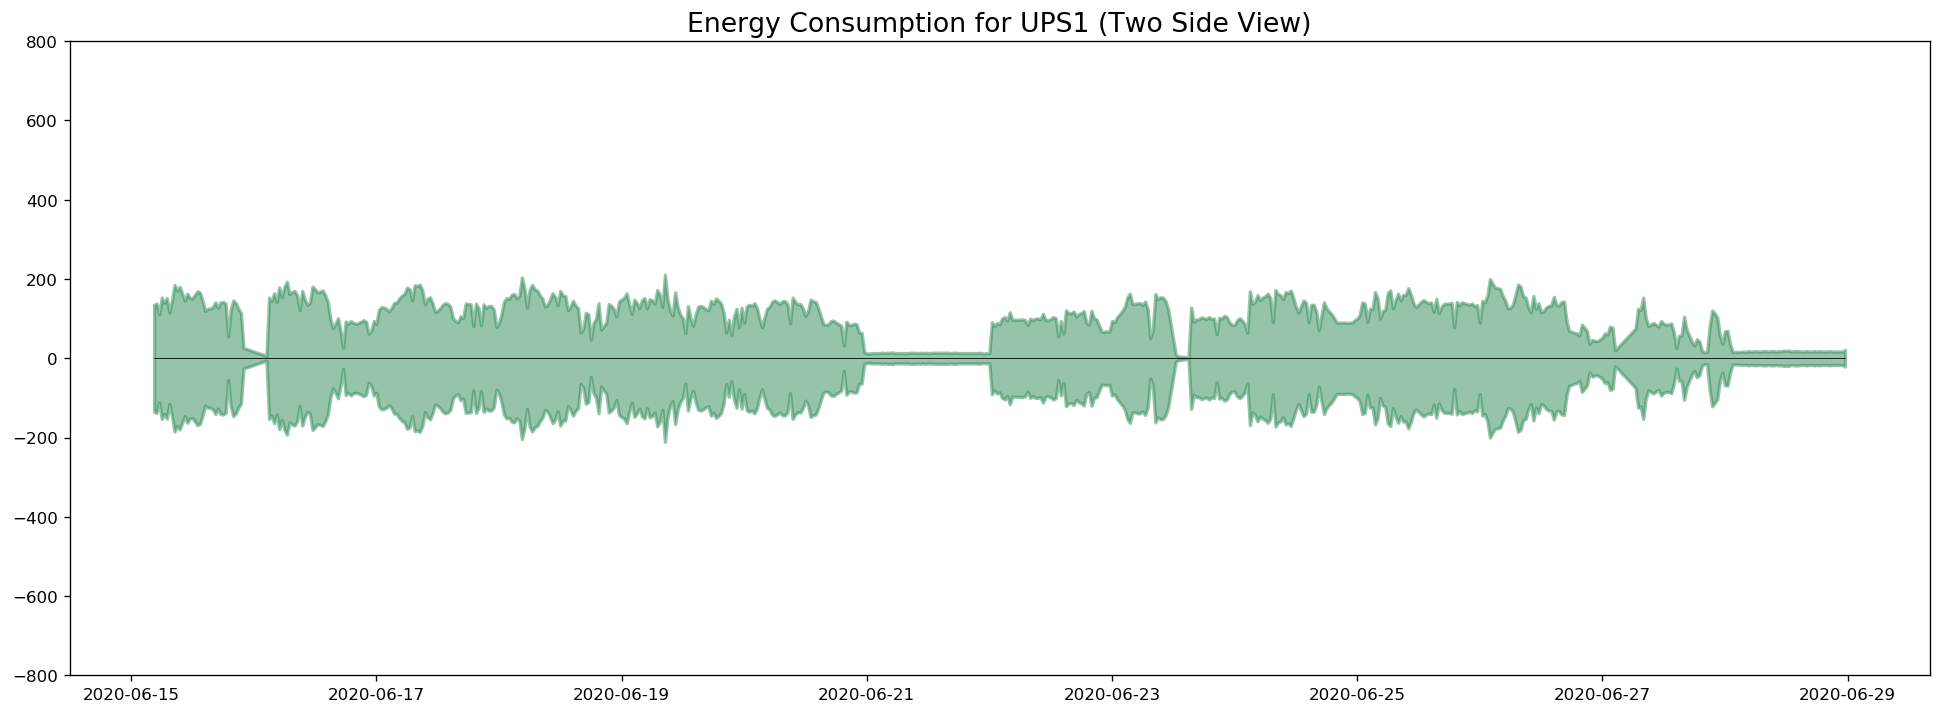

In [11]:
import matplotlib.pyplot as plt
y1 = EM4['EM4'].values
# Plot
fig, ax = plt.subplots(1, 1, figsize=(20,7), dpi= 120)
plt.fill_between(df.index, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Energy Consumption for UPS1 (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

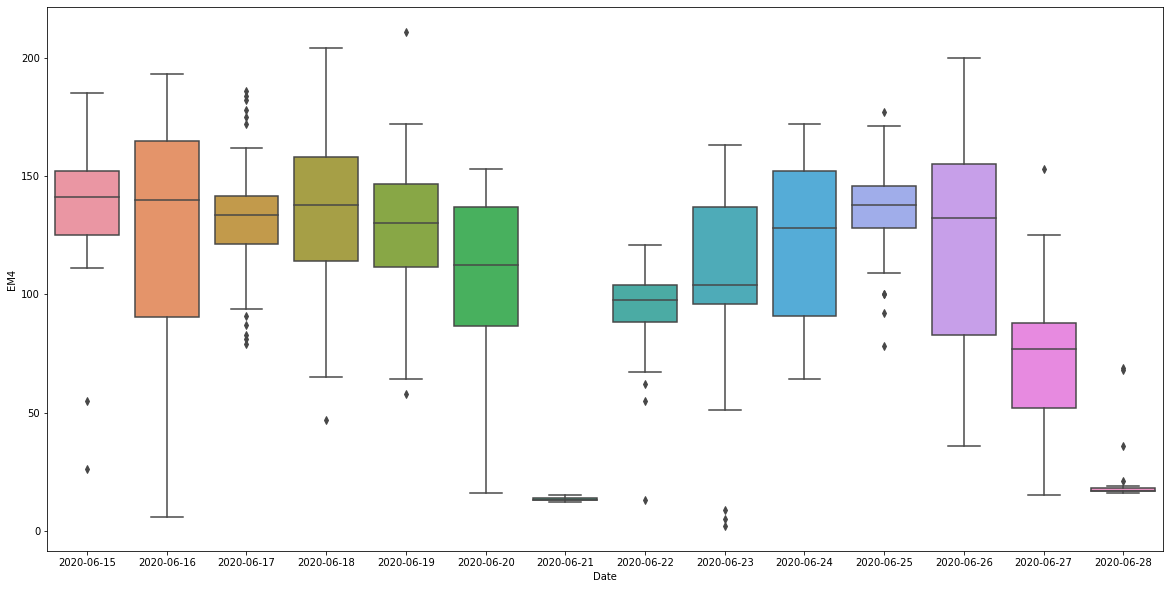

In [12]:
plt.figure(figsize=(20,10))
EM4['Date'] = [d.date() for d in EM4.index]
sns.boxplot(x="Date", y="EM4",data=EM4)

# Anomilies Detection

In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.645, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", lw = 3)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", lw = 2)
        plt.plot(lower_bond, "r--", lw = 2)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", lw = 3)
    plt.legend(loc="upper left")
    plt.grid(True)

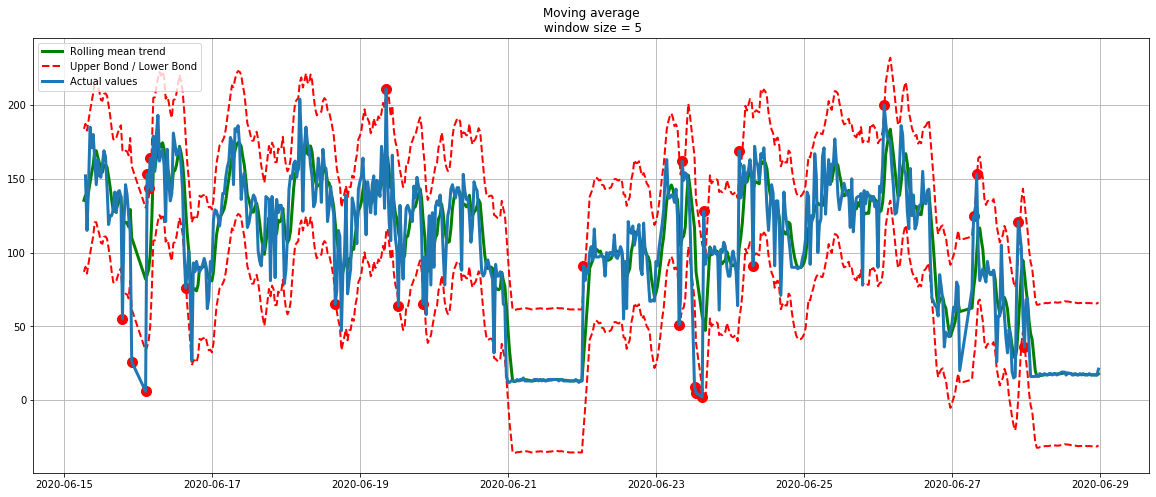

In [15]:
energy_anomaly = pd.DataFrame(EM4['EM4'].copy())
# energy_anomaly.iloc[-20] = energy_anomaly.iloc[-20] * 0.2 # say we have 80% drop of energy 
plotMovingAverage(energy_anomaly, 5, plot_intervals=True, plot_anomalies=True)

# Removing Only the anomalies

In [16]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
data2 = EM4.copy()
energy_anomaly = pd.DataFrame(data2['EM4'])
rolling_mean = energy_anomaly.rolling(window=5).mean()
mae = mean_absolute_error(energy_anomaly[5:], rolling_mean[5:])
deviation = np.std(energy_anomaly[5:] - rolling_mean[5:])
lower_bond = rolling_mean - (mae + 1.645 * deviation)
upper_bond = rolling_mean + (mae + 1.645 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [18]:
#anomalies

In [19]:
len(EM4)

643

In [20]:
len(anomalies)

25

In [21]:
data2.loc[anomalies.index,'EM4'] = np.nan 

In [22]:
# For Anomalies
# Linear Interpolation
new1_data2 = data2.interpolate()
# new1_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [23]:
# For Anomalies
# Time Interpolation
new2_data2 = data2.interpolate(method = 'time')
# new2_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [24]:
# For Anomalies
# Cubic Interpolation
new3_data2 = data2.interpolate(method = 'cubic')
# new3_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

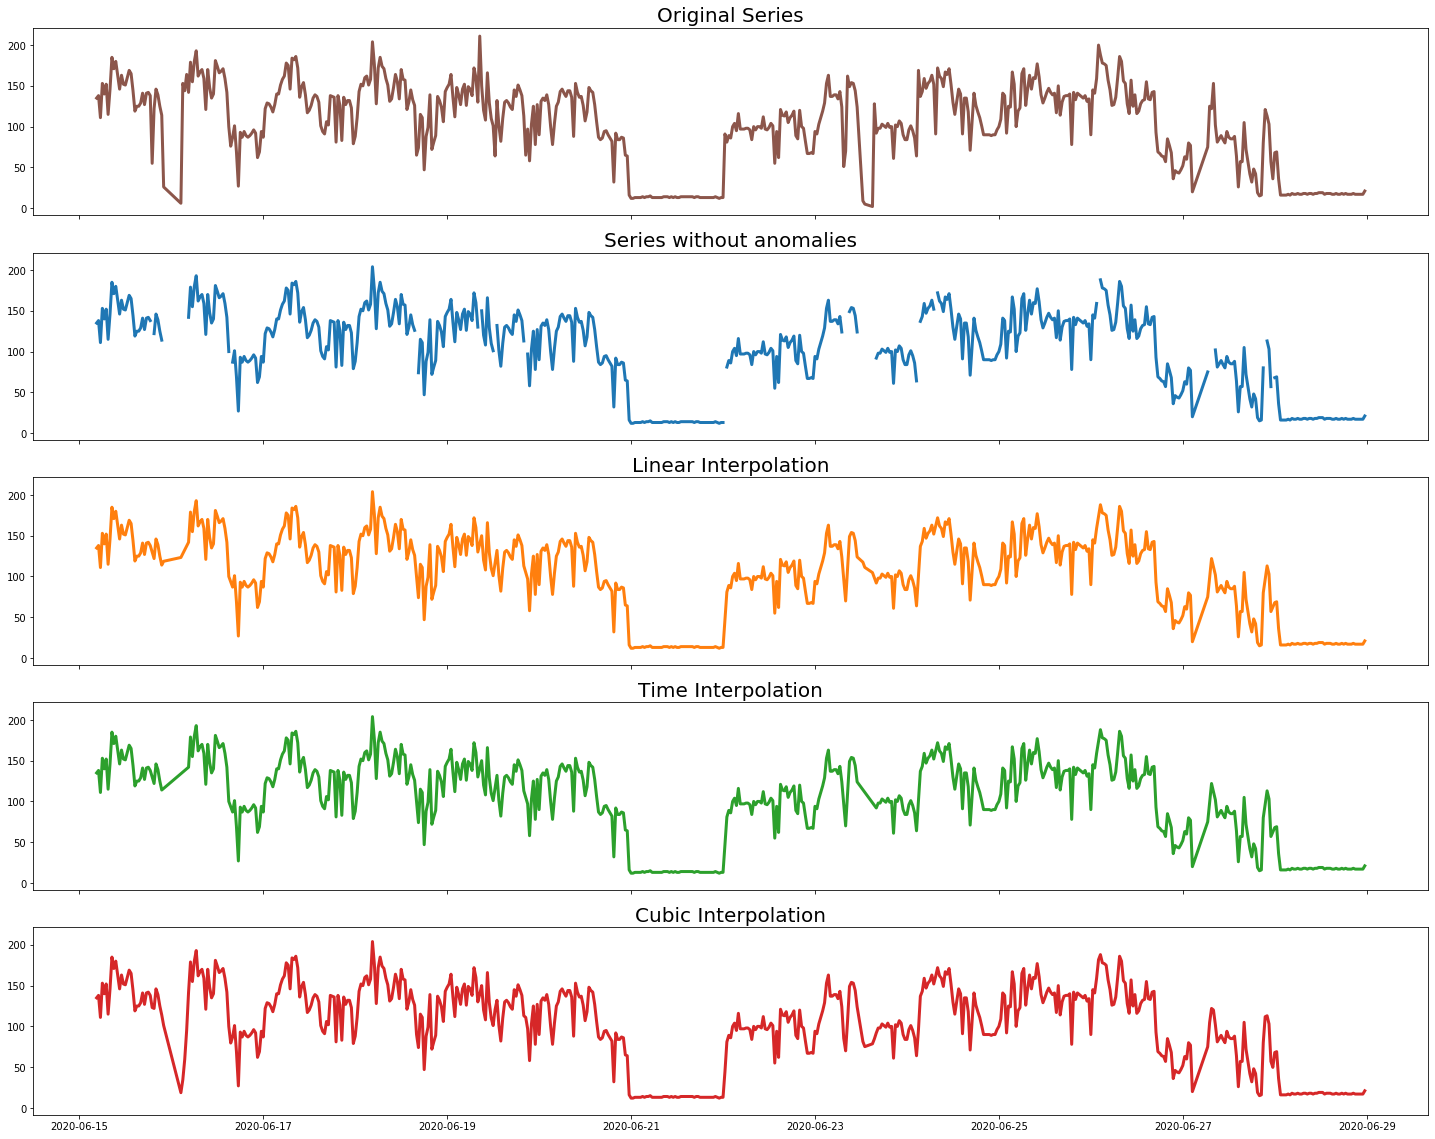

In [25]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,20))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(data2.index, data2['EM4'], 'tab:blue', linewidth = 3)
axs[1].set_title('Series without anomalies', fontsize = 20)
axs[2].plot(new1_data2.index, new1_data2['EM4'], 'tab:orange', linewidth = 3)
axs[2].set_title('Linear Interpolation', fontsize = 20)
axs[3].plot(new2_data2.index, new2_data2['EM4'], 'tab:green', linewidth = 3)
axs[3].set_title('Time Interpolation', fontsize = 20)
axs[4].plot(new3_data2.index, new3_data2['EM4'], 'tab:red', linewidth = 3)
axs[4].set_title('Cubic Interpolation', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [26]:
# Linear Interpolation
from statsmodels.tsa.stattools import adfuller
result_o = adfuller(EM4['EM4'])
result_l = adfuller(new1_data2['EM4'])
result_t = adfuller(new2_data2['EM4'])
result_c = adfuller(new3_data2['EM4'])

In [27]:
P_value = [result_o[1], result_l[1], result_t[1], result_c[1]]
ADF_Statistics = [result_o[0], result_l[0], result_t[0], result_c[0]]
Result = pd.DataFrame(P_value, ADF_Statistics).reset_index()
Result = Result.rename(columns={'index': 'ADF Statistics', 0: 'P-Value'})
Result = Result.T
Result = Result.rename(columns={0: 'Original', 1: 'Linear', 2: 'Time', 3: 'Cubic'})
Result

,Original,Linear,Time,Cubic
ADF Statistics,-3.235282,-3.021677,-3.016710,-3.412854
P-Value,0.018031,0.032919,0.033363,0.010528


# Considering series with cubic interpolation for further analysis as it has least p-value and highest negative ADF Statistics value which makes it more stationary than the other series

In [28]:
# new3_data2 = data2.interpolate(method = 'cubic')
EM4_cubic = new3_data2.copy()
EM4_cubic = EM4_cubic.drop(['Date'], axis = 1)
EM4_cubic.head()

,EM4
,
2020-06-15 04:30:00,135.0
2020-06-15 05:00:00,138.0
2020-06-15 05:30:00,111.0
2020-06-15 06:00:00,153.0
2020-06-15 06:30:00,140.0


In [29]:
EM4_cubic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 643 entries, 2020-06-15 04:30:00 to 2020-06-28 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EM4     643 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


In [30]:
EM4_cubic.reset_index()

,,EM4
0,2020-06-15 04:30:00,135.0
1,2020-06-15 05:00:00,138.0
2,2020-06-15 05:30:00,111.0
3,2020-06-15 06:00:00,153.0
4,2020-06-15 06:30:00,140.0
...,...,...
638,2020-06-28 21:30:00,17.0
639,2020-06-28 22:00:00,17.0
640,2020-06-28 22:30:00,17.0
641,2020-06-28 23:00:00,17.0


In [31]:
# 558*0.9

In [32]:
EM4_cubic.iloc[500]

EM4    139.0
Name: 2020-06-25 21:00:00, dtype: float64

In [33]:
#Creating train and test set 
#Index 446 marks 24th June 2020 16:00
train = EM4_cubic[0:500] 
test = EM4_cubic[501:]

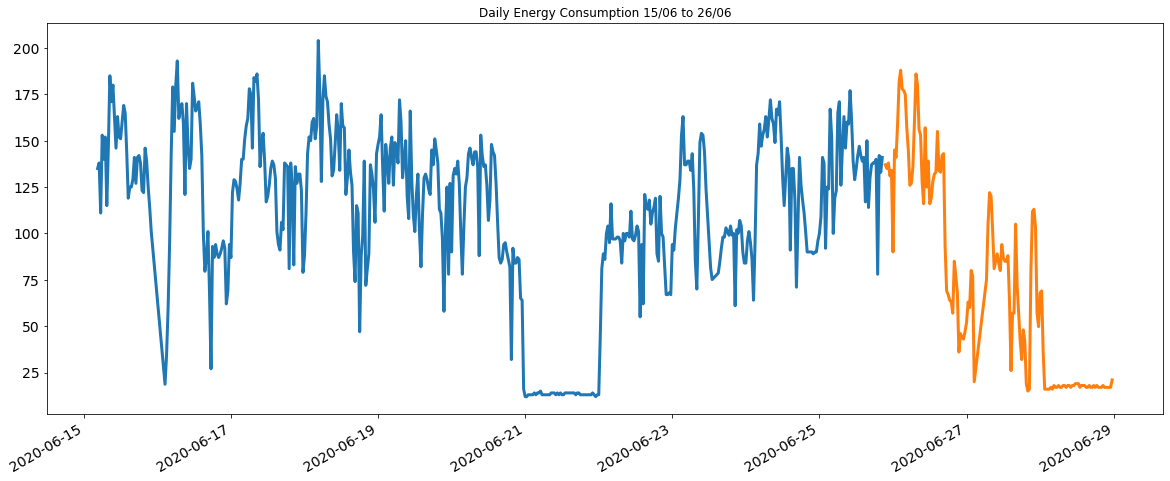

In [34]:
# Let’s visualize the data (train and test together) to know how it varies over a time period.
# Plotting data
train.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
test.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
plt.show()

# Method 1 – Simple average

- We can infer from the graph that the price of the coin is increasing and decreasing randomly by a small margin, such that the average remains constant. Many a times we are provided with a dataset, which though varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

- Such forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

- We take all the values previously known, calculate the average and take it as the next value. Of course it won’t be it exact, but somewhat close.

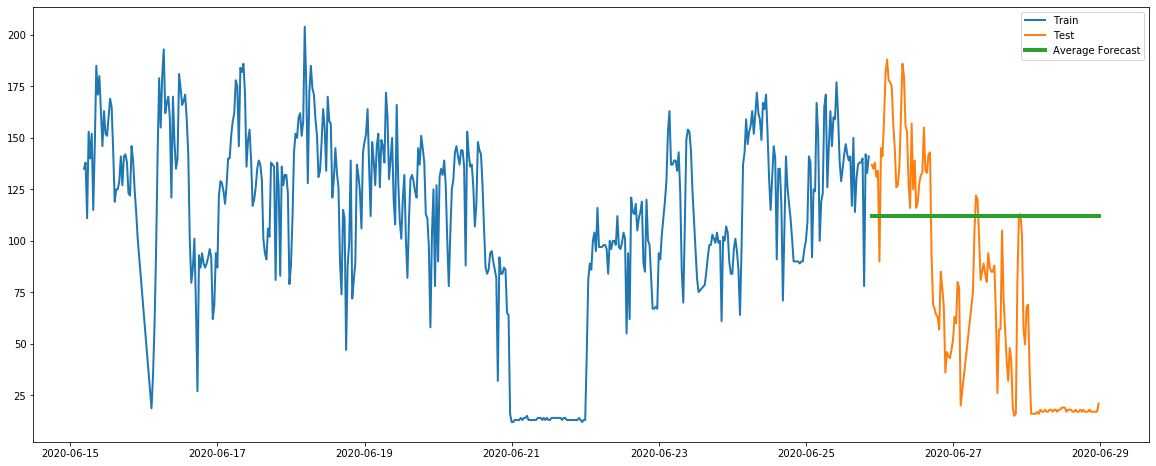

In [35]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['EM4'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label = 'Train', lw = 2)
plt.plot(test['EM4'], label = 'Test', lw = 2)
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast', lw = 4)
plt.legend(loc = 'best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.avg_forecast))
print(rms)

65.8013199852733


We can see that this model didn’t improve our score. 
Hence we can infer from the score that this method works best when the average at each time period remains constant.

# Method 2 – Single Exponential smoothing

- Both Simple average and Weighted moving average lie on completely opposite ends. We would need something between these two extremes approaches which takes into account all the data while weighing the data points differently. For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing.

- Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

- The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

- So essentially we’ve got a weighted moving average with two weights: α and 1−α.
As we can see, 1−α is multiplied by the previous expected value ŷ x−1 which makes the expression recursive. And this is why this method is called Exponential. The forecast at time t+1 is equal to a weighted average between the most recent observation yt and the most recent forecast ŷ t|t−1.

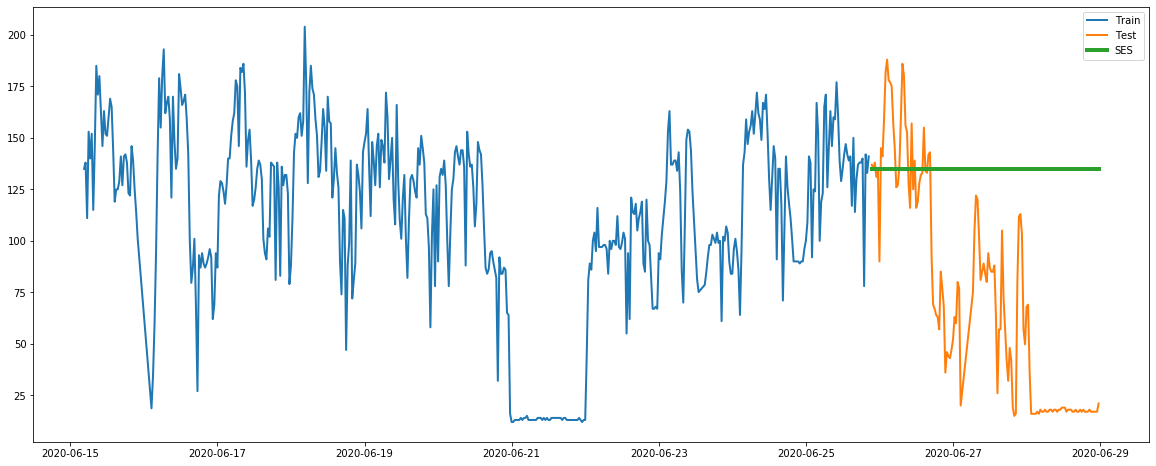

In [37]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['EM4'])).fit(smoothing_level = 0.5, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train', lw =2)
plt.plot(test['EM4'], label='Test', lw =2)
plt.plot(y_hat_avg['SES'], label='SES', lw = 4)
plt.legend(loc='best')
plt.show()

In [38]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.SES))
print(rms)

81.62447404937804


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.

# Method 3 – Holt’s Winter seasonal method

C:\Users\u23e02\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


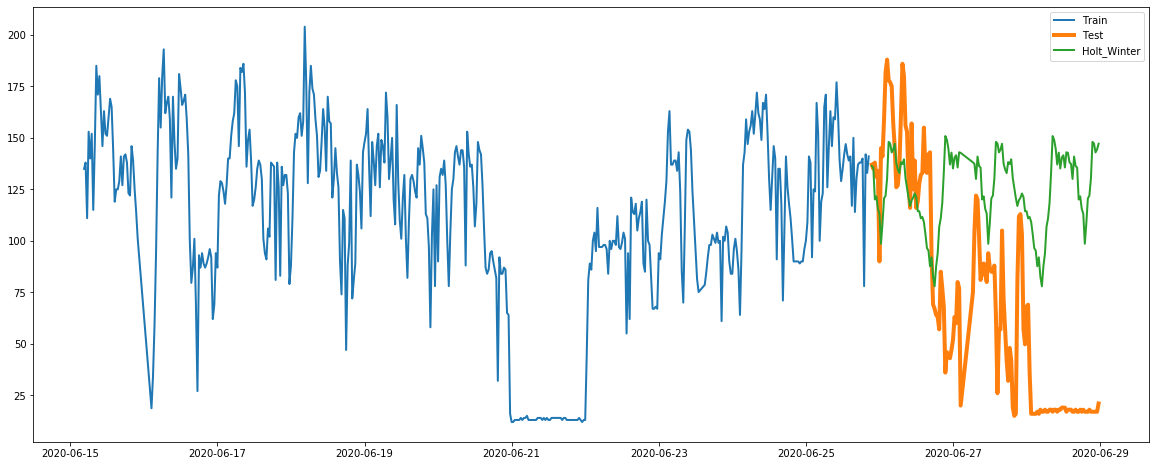

In [39]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 63, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['EM4'], label='Train', lw = 2)
plt.plot(test['EM4'], label='Test', lw = 4)
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', lw = 2)
plt.legend(loc='best')
plt.show()

In [40]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
print(rms)

76.21257016634473


# Method 7 – ARIMA

In [41]:
# y_hat_avg = test.copy()
# fit1 = sm.tsa.statespace.SARIMAX(train.EM4, order=(2, 1, 4), seasonal_order=(0,1,1,7)).fit()
# y_hat_avg['SARIMA'] = fit1.predict(start = '2020-06-24 16:00:00', end = "2020-06-26 23:59:59", dynamic=True)
# plt.figure(figsize=(20,8))
# plt.plot( train['EM4'], label='Train')
# plt.plot(test['EM4'], label='Test')
# plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
# plt.legend(loc='best')
# plt.show()

C:\Users\u23e02\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


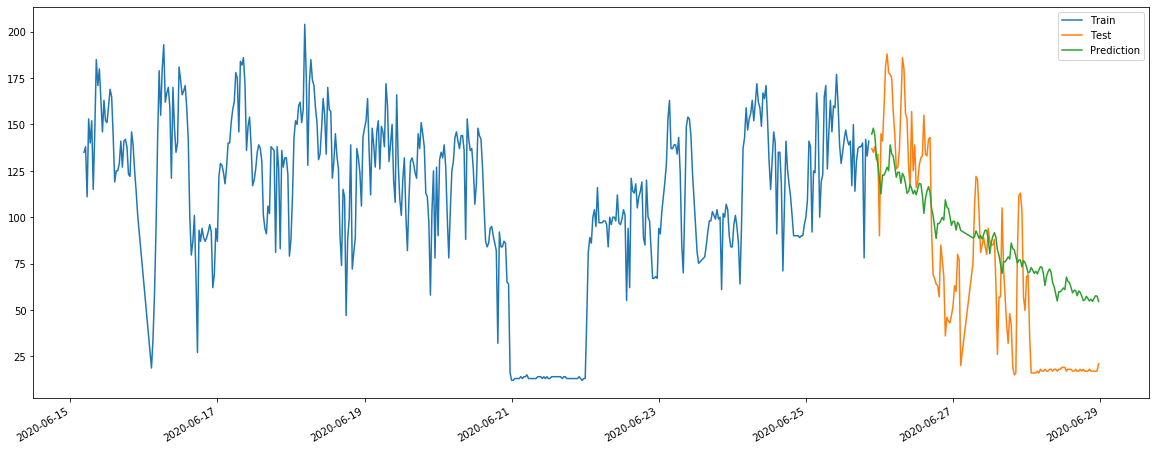

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']), trend = 'mul', seasonal = 'mul', seasonal_periods= 36).fit()
y_hat_avg['model'] = fit1.forecast(len(test))
train['EM4'].plot(legend = True, label = 'Train', figsize=(20,8))
test['EM4'].plot(legend = True, label = 'Test', figsize=(20,8))
y_hat_avg['model'].plot(legend = True, label = 'Prediction', figsize=(20,8))

# Types of linear regression :

- LinearRegression implements a linear regression model for performing ordinary least squares regression using one of the following five approaches:

    - Normal Equations
    - QR Decomposition Method
    - SVD (Singular Value Decomposition) method
    - Gradient Descent
    - Stochastic Gradient Descent

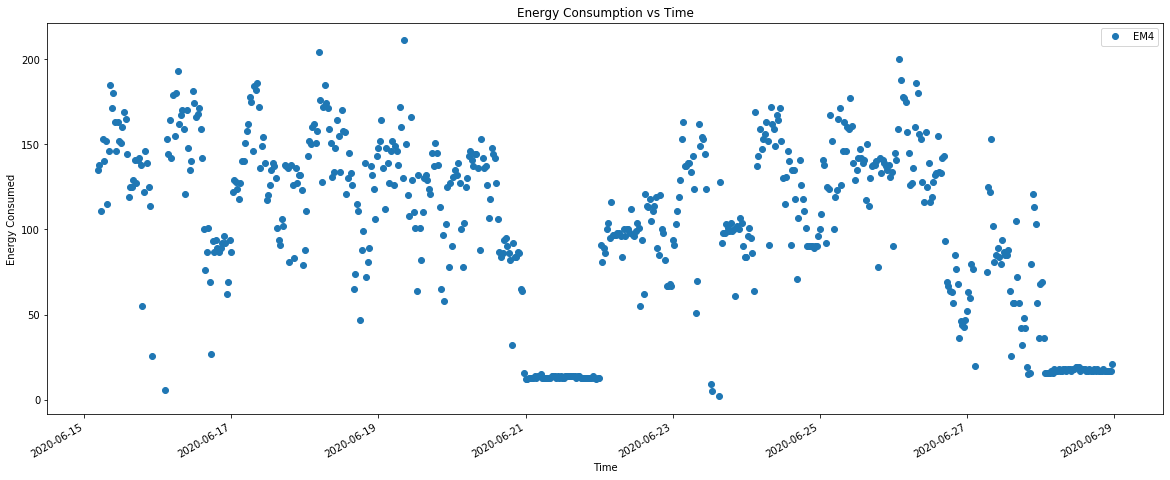

In [43]:
EM4.plot(y = 'EM4', style='o', figsize = (20,8))
plt.title('Energy Consumption vs Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumed')
plt.show()

# Time Series to Supervised Learning 

In [44]:
from pandas import DataFrame
df = EM4_cubic.copy()
print(df.head())

                       EM4
                          
2020-06-15 04:30:00  135.0
2020-06-15 05:00:00  138.0
2020-06-15 05:30:00  111.0
2020-06-15 06:00:00  153.0
2020-06-15 06:30:00  140.0


In [45]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [46]:
values = [x for x in range(10)]
data = series_to_supervised(values)
print(data)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


In [47]:
data = series_to_supervised(values, 5)
print(data)

   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
5        0.0        1.0        2.0        3.0        4.0        5
6        1.0        2.0        3.0        4.0        5.0        6
7        2.0        3.0        4.0        5.0        6.0        7
8        3.0        4.0        5.0        6.0        7.0        8
9        4.0        5.0        6.0        7.0        8.0        9
